In [1]:
from gptopt.optim.attn_kq import * 
from utils_pdhg import *
from gptopt.optim.least_squares import * 

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=75$

In [19]:
m = n = 75
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.05
mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=1.0411e+02


In [20]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [21]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [22]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [23]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)
print(pd_residuals_infty_ball(A=A, B=B, Y=torch.from_numpy(Y_star).to(G1.dtype).to(G1.device), 
                              Z1=torch.from_numpy(Z_star_1).to(G1.dtype).to(G1.device), 
                              Z2=torch.from_numpy(Z_star_2).to(G1.dtype).to(G1.device), 
                                      G1=G1, G2=G2, beta=beta, mu=0))

f_star=-3.7780e+00, -3.7779717445373535, 
cvxpy constraint violation: 6.109476088922428e-07
(6.858614597149426e-07, 1.8289638925731803e-07, 1.506825770044986e-06, 3.8937865140074154e-07)


In [24]:
residuals_cold_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
(Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                              tol=1e-10, maxit=100, diag_scaling=True)
r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0)
print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")   
residuals_warm_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=f_star, stopping=False, max_iter=max_iter, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -3.776464e+00  1.637969e-01
rehpdhg       -3.862077e+00  7.257262e-02
pdhg ds       -3.778464e+00  1.180527e-01
rehpdhg ds    -3.875804e+00  9.149456e-02
ada rehpdhg   -3.776028e+00  7.249653e-03
ada rehpdhg ds  -3.777063e+00  7.753611e-03
init r1_rel=1.9999e+00, r2_rel=1.5807e-03
Method                 Obj          Viol
----------------------------------------
init          3.777512e+00  5.840370e-02
pdhg          -3.777182e+00  1.621705e-01
rehpdhg       -3.771367e+00  3.447981e-02
pdhg ds       -3.777471e+00  1.320669e-01
rehpdhg ds    -3.775008e+00  1.319999e-02
ada rehpdhg   -3.771191e+00  1.973936e-02
ada rehpdhg ds  -3.775116e+00  1.193376e-02


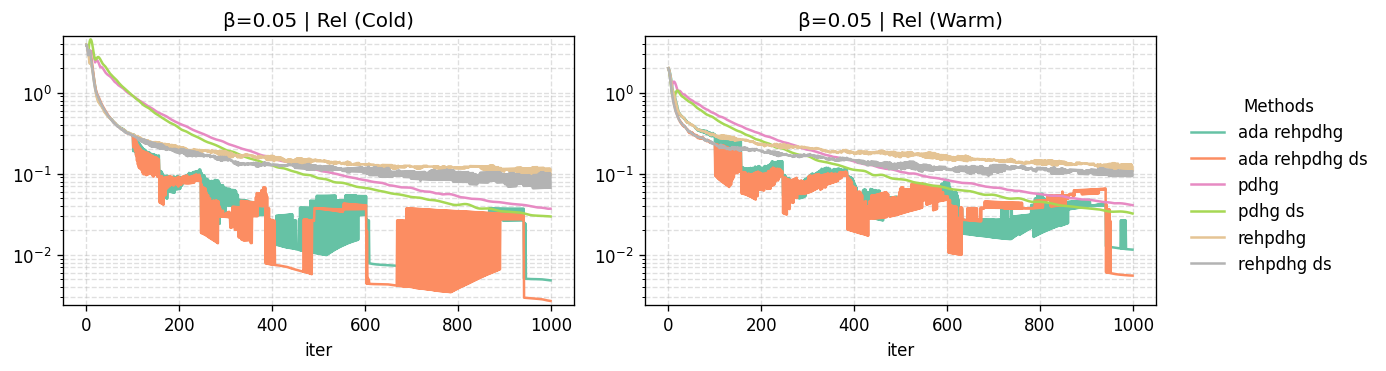

In [25]:
_ = plot_residuals_cold_warm_grid_by_param(
    {beta:residuals_cold_start},
    {beta:residuals_warm_start},
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [12]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7620e+00


In [14]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0)
    print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")
    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5, theta=1)

beta=0.001, lamb_max=3.7620e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.730917e-01  4.148896e-01
rehpdhg       -9.805725e-01  6.156326e-02
pdhg ds       -9.849759e-01  3.711535e-01
rehpdhg ds    -9.931419e-01  5.505530e-02
ada rehpdhg   -9.642490e-01  5.802657e-02
ada rehpdhg ds  -9.767851e-01  5.132046e-02
init r1_rel=1.9998e+00, r2_rel=2.6551e-04
Method                 Obj          Viol
----------------------------------------
init          1.000175e+00  6.463744e-02
pdhg          -9.030147e-01  4.575185e-01
rehpdhg       -8.898622e-01  9.746645e-02
pdhg ds       -9.460300e-01  5.873632e-01
rehpdhg ds    -9.359744e-01  9.396270e-02
ada rehpdhg   -8.472672e-01  9.050109e-02
ada rehpdhg ds  -8.994324e-01  6.213661e-02
beta=0.0005, lamb_max=3.7620e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933555e-01  7.201445e-01
rehpdhg       -5.008972e-01  8.107924e-02
pdhg ds       

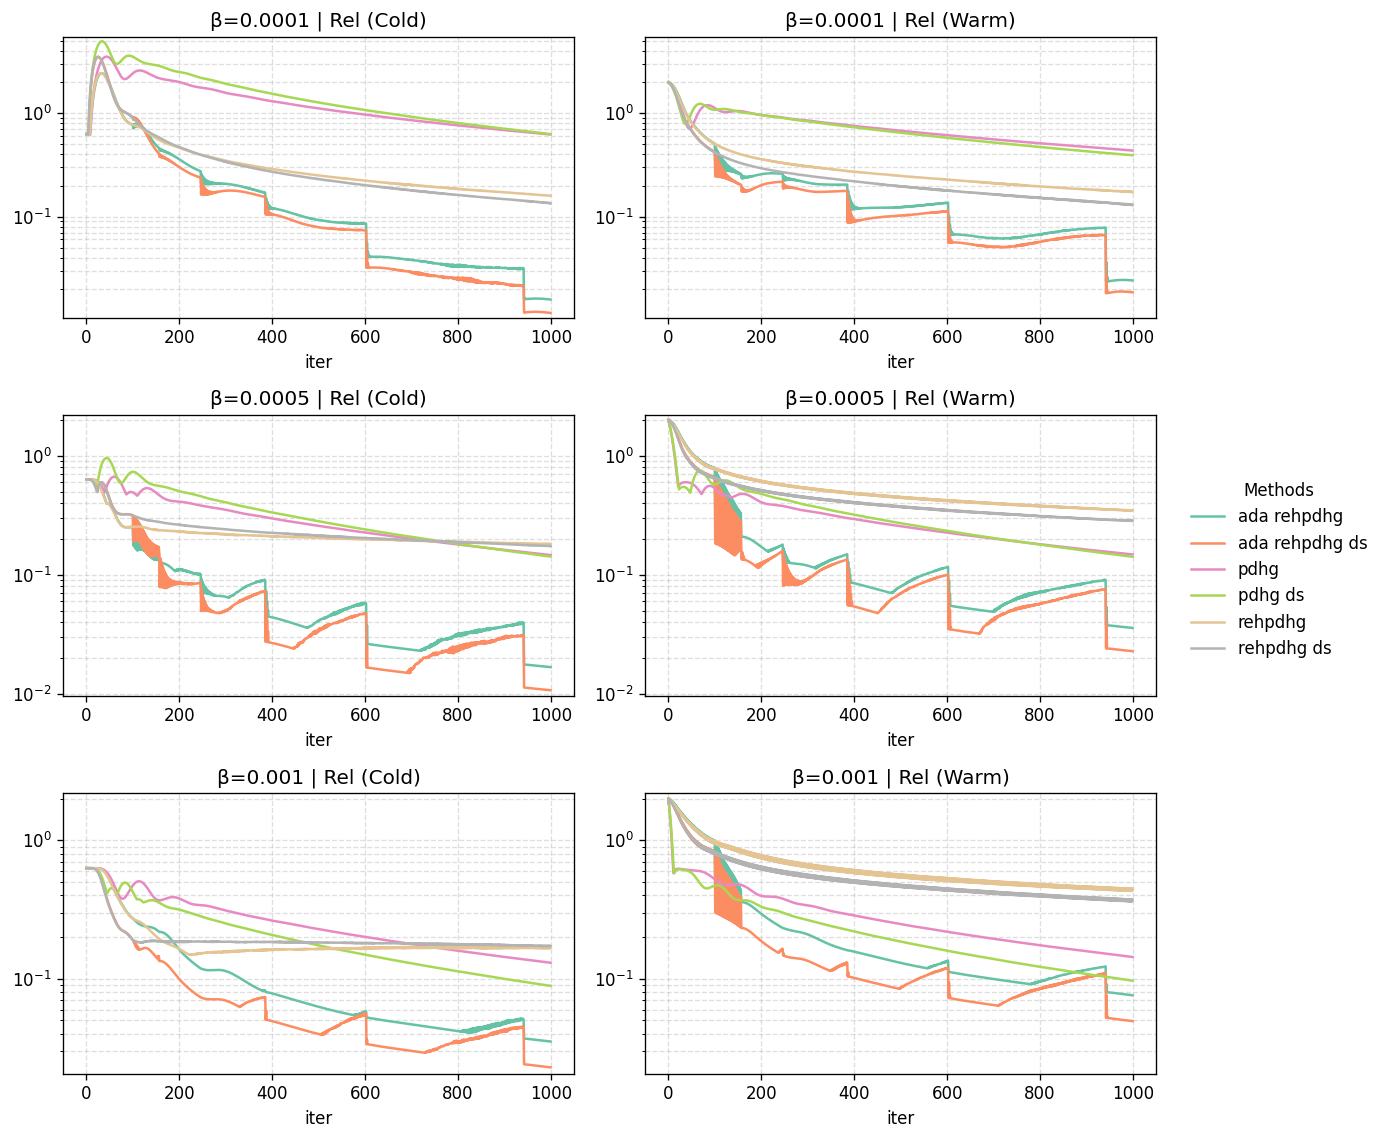

In [15]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [16]:
m = n = 1000
std2 = 0.1
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9973e+00


In [17]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0)
    print(f"init {r1=:.4e}, {r2=:.4e}, {r1_rel=:.4e}, {r2_rel=:.4e}")
    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)
    

beta=0.001, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.855155e-02  9.530077e-02
rehpdhg       -7.819441e-02  3.266595e-02
pdhg ds       -8.685040e-02  9.612802e-02
rehpdhg ds    -8.693184e-02  4.146474e-02
ada rehpdhg   -5.967643e-02  2.535845e-02
ada rehpdhg ds  -7.544692e-02  2.210790e-02
init r1=1.9993e+00, r2=1.6475e-05, r1_rel=1.9993e+00, r2_rel=8.2756e-05
Method                 Obj          Viol
----------------------------------------
init          1.000198e-01  6.342207e-02
pdhg          -1.989919e-02  1.216546e-01
rehpdhg       -1.967793e-02  4.746630e-02
pdhg ds       -4.927937e-02  1.180770e-01
rehpdhg ds    -4.873762e-02  4.359153e-02
ada rehpdhg   6.075737e-02  1.811897e-04
ada rehpdhg ds  3.375674e-02  3.225769e-02
beta=0.0005, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.412984e-02  1.317712e-01
rehpdhg       -4.417939e-02 

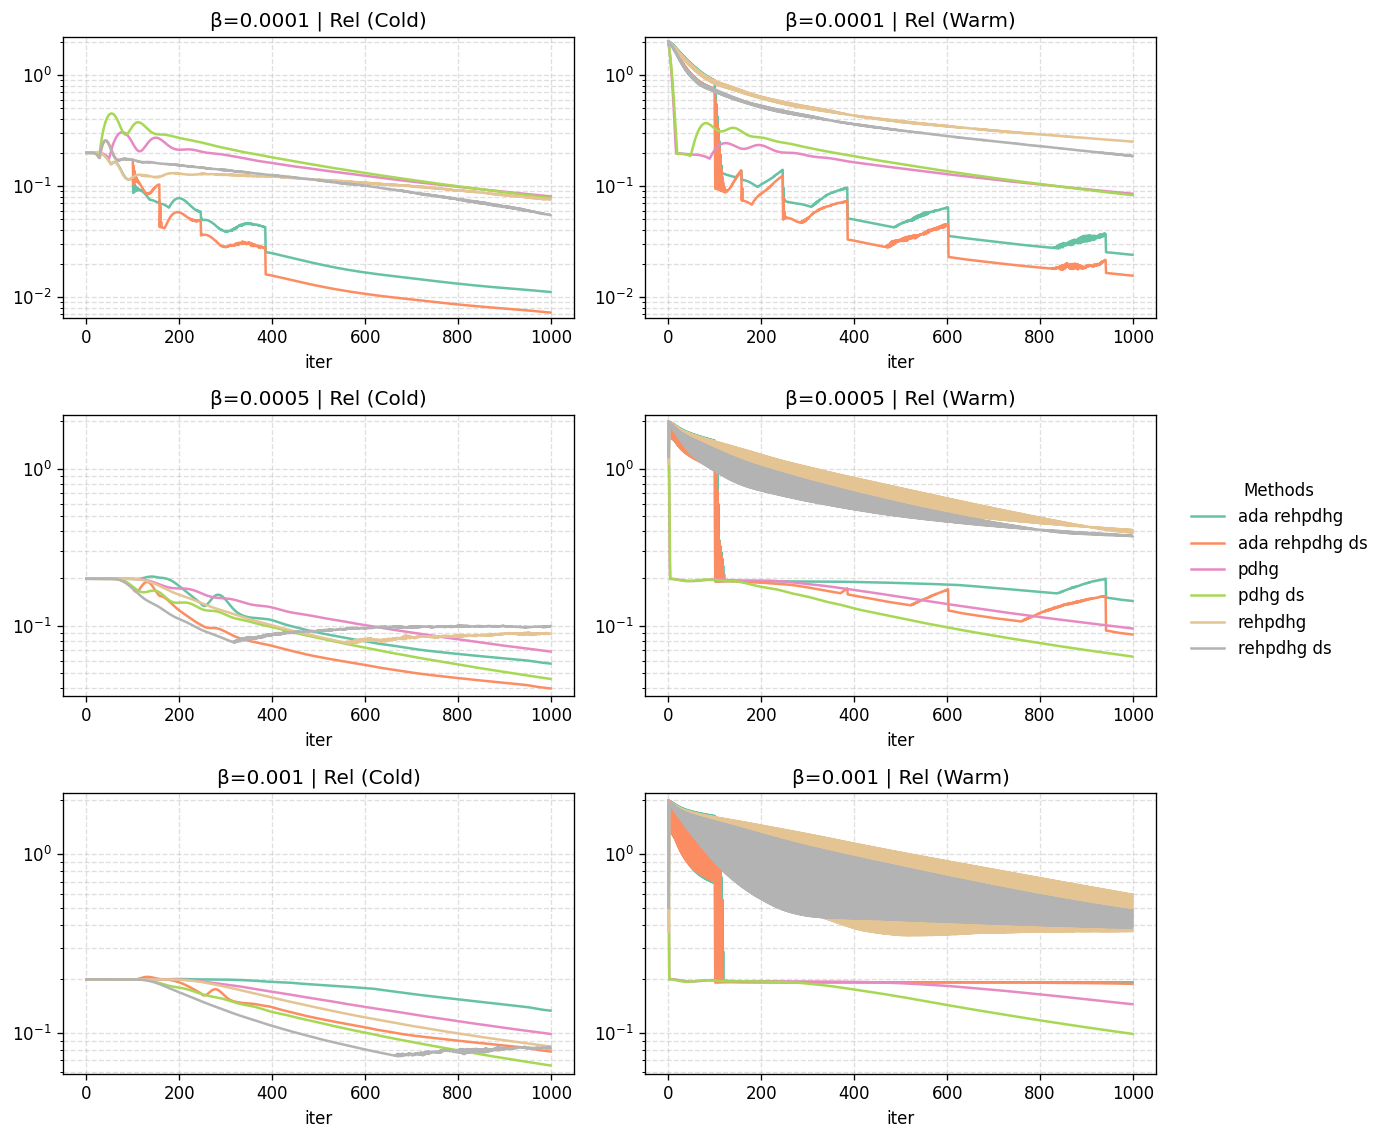

In [18]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)